## Machine Learning Workflow

![ML_workflow](ML_workflow.jpg)

## Step 1: Set Up Virtual Environment

`conda create --prefix C:\Users\...\wl_time_series`

`conda activate C:\Users\...\wl_time_series`

## Step 2: Install & Load Necessary Packages (Re-run)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Step 3: ETL (Extract, Transform, Load) Data

### Description of features
- **time_met**: Time variable of meteorological measurements.
- **crain**: Categorical variable indicating rain (1 = raining, 0 = not raining).
- **mslp**: Mean sea level pressure (Pa).
- **tcc**: Total cloud cover (%).
- **tp**: Total precipitation (kg/m²).
- **u10**: U-component of 10-meter wind speed (m/s).
- **v10**: V-component of 10-meter wind speed (m/s).
- **wl_pred**: Predicted (tidal) water level (m NAVD88).

### Description of target
- **wl_obs**: Observed water level – this is the variable we want to predict (m NAVD88).


## Step 4: Data Cleaning & Aggregation (Re-run)

In [4]:
df = pd.read_csv('wl_ts_data.csv')

# Drop columns
df = df.drop(['time_wl_obs','time_wl_pred'], axis=1)

# Drop rows
df['time_met'] = pd.to_datetime(df['time_met'])
start_date = pd.to_datetime('2023-04-01 04:00:00')
end_date = pd.to_datetime('2024-04-30 04:00:00')
df = df[(df['time_met'] > start_date) & (df['time_met'] < end_date)].reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9479 entries, 0 to 9478
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   crain     9479 non-null   int64         
 1   mslp      9479 non-null   float64       
 2   tcc       9479 non-null   float64       
 3   time_met  9479 non-null   datetime64[ns]
 4   tp        9479 non-null   float64       
 5   u10       9479 non-null   float64       
 6   v10       9479 non-null   float64       
 7   wl_obs    9479 non-null   float64       
 8   wl_pred   9479 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 666.6 KB


## Step 5: Train-Test Split (Re-run)

In [6]:
X = df.drop(['time_met','wl_obs'], axis=1)
y = df['wl_obs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 6: Exploratory Data Analysis (EDA)

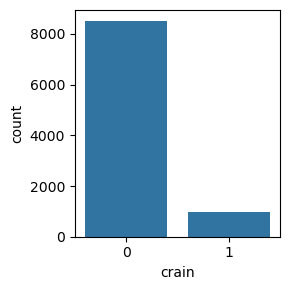

In [8]:
plt.figure(figsize=(3, 3))

# Categorical variable
cat_col = ['crain']

# Bar plot
sns.countplot(x=cat_col[0], data=df)

plt.tight_layout()
plt.show()

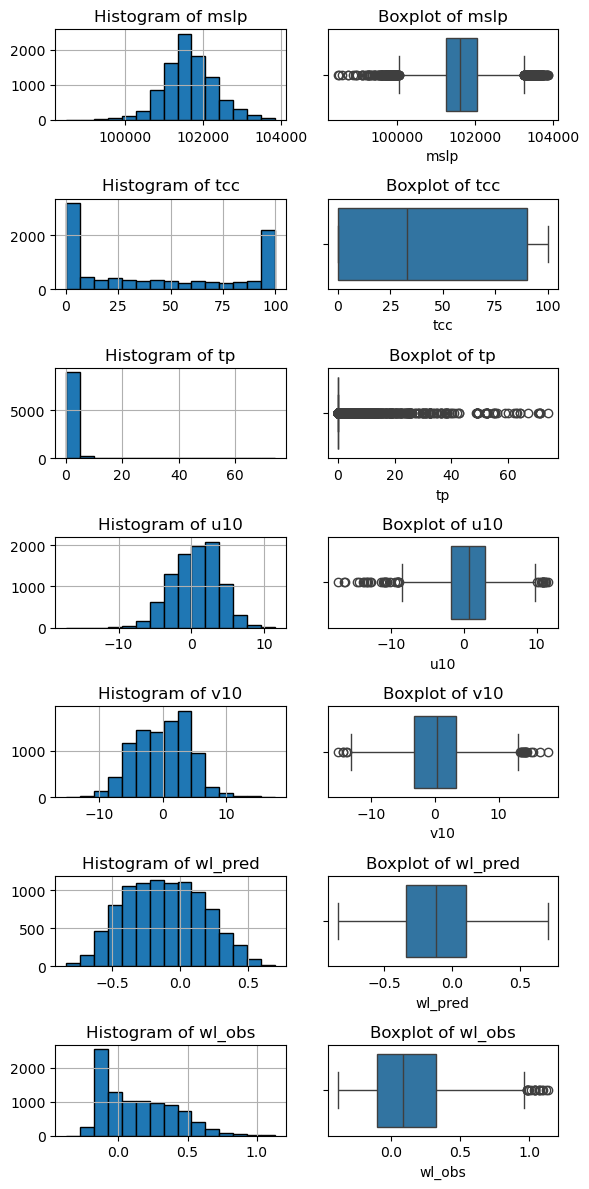

In [10]:
plt.figure(figsize=(6, 12))

# Numerical variables
num_cols = ['mslp','tcc','tp','u10','v10','wl_pred','wl_obs']

for i, col in enumerate(num_cols, start=1):
    # Left column: Histogram
    plt.subplot(7, 2, 2*i-1)
    df[col].hist(bins=15, edgecolor='black')
    plt.title(f"Histogram of {col}")
    
    # Right column: Box plot
    plt.subplot(7, 2, 2*i)
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

## Step 7: Feature Engineering (Re-run)

### Two strategies of normalization:

- **Min-max normalization**: (value - min)/(max - min)

- **Z-score standardization**: (value - $\mu$)/$\sigma$

In [12]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), ['tcc']),
        ('zscore', StandardScaler(), ['mslp','tp','u10','v10','wl_pred']),
        ('encode', OneHotEncoder(drop='first', sparse_output=False), ['crain'])
    ],
    remainder='passthrough')

# Normalization should only be applied to the training set, 
# and then the same transformation should be applied to the test set
X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

### Correlation analysis

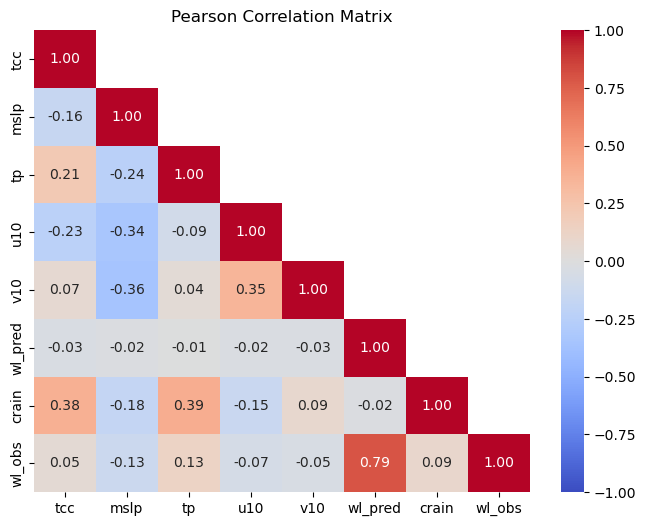

In [14]:
columns = ['tcc','mslp','tp','u10','v10','wl_pred','crain','time_met','wl_obs']
dfc = pd.DataFrame(preprocessor.fit_transform(df), columns=columns)
dfc = dfc.drop('time_met', axis=1)

# Visualize the correlation
plt.figure(figsize=(8, 6))
sns.heatmap(dfc.corr(), vmin=-1, vmax=1, center=0, fmt='.2f', annot=True, 
            cmap='coolwarm', mask=np.triu(np.ones_like(dfc.corr()), 1))
plt.title('Pearson Correlation Matrix')
plt.show()

## Step 8: Model Selection & Implementation

In [16]:
# Use ridge regression with L2-norm regularization as the base model
# Prevent overfitting by adding a penalty term to the loss function
base_model = Ridge(alpha=0.1)
base_model.fit(X_train_p, y_train)
y_pred = base_model.predict(X_test_p)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared (R²): {r2:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')

R-squared (R²): 0.6590
Mean Absolute Error (MAE): 0.1162
Mean Squared Error (MSE): 0.0226
